<a href="https://colab.research.google.com/github/NoorFatimaMemon/DeepLearning/blob/main/26_Intro_to_Autoencoders/26_Anomaly_Detection_with_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Credit Card Fraud Detection using Autoencoder (AE)**

We will use an AE to detect fraud in credit card transactions. The dataset includes:
- 0: Normal
- 1: Fraudulent

Since fraud is rare (~0.17% of data), this suits anomaly detection. Our steps:

1. Train AE on normal transactions only.
2. AE learns to reconstruct normal data well.
3. Fraudulent data yields high reconstruction error.
4. Flag transactions with high error as fraud.

This method is ideal when:
- Anomalies are rare.
- Labeled fraud data is limited.

### Import libraries

In [62]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

### Load the Credit Card Fraud Dataset

In [45]:
# Download the dataset
df = pd.read_csv("https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [46]:
print(df['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


### Prepare the Data

In [47]:
labels = df['Class']
data = df.drop(['Class', 'Time'], axis=1)

In [48]:
# Normalize feature values
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

### Split into Train/Test Sets

In [49]:
X_train, X_test, y_train, y_test = train_test_split(data_scaled, labels, test_size=0.2, random_state=42)

### Separate Normal and Fraud Transactions

In [50]:
X_train_norm = X_train[y_train == 0]
X_test_norm = X_test[y_test == 0]
X_test_anom = X_test[y_test == 1]

### Build the model

In [51]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([layers.Dense(16, activation="relu"),
                                            layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([layers.Dense(16, activation="relu"),
                                            layers.Dense(29, activation="sigmoid")])  # Input has 29 features

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

### Train the Autoencoder on Normal Transactions

In [52]:
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
history = autoencoder.fit(X_train_norm, X_train_norm, epochs=50, batch_size=256,
                          validation_data=(X_test_norm, X_test_norm), callbacks=[early_stop], shuffle=True)

Epoch 1/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6666 - val_loss: 0.5743
Epoch 2/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5710 - val_loss: 0.5577
Epoch 3/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5550 - val_loss: 0.5483
Epoch 4/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5470 - val_loss: 0.5418
Epoch 5/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5402 - val_loss: 0.5387
Epoch 6/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5378 - val_loss: 0.5361
Epoch 7/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5366 - val_loss: 0.5338
Epoch 8/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5336 - val_loss: 0.5308
Epoch 9/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5302 - val_loss: 0.5280
Epoch 10/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5290 - val_loss: 0.5266
Epoch 11/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5264 - val_loss: 0.5256
Epoch 12/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

### Visualize Training Loss

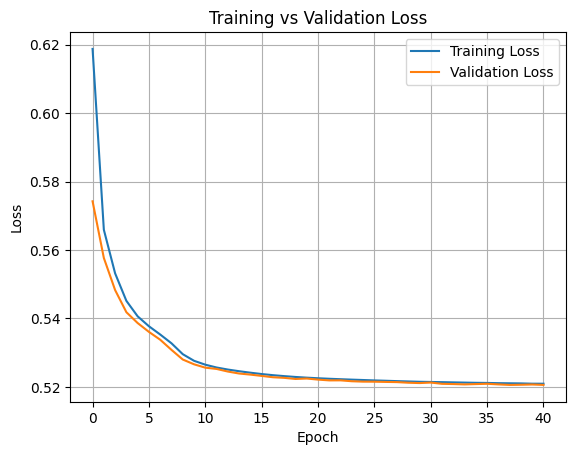

In [58]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

### Calculate Reconstruction Error on Training Set

In [54]:
reconstructions = autoencoder.predict(X_train_norm)
train_loss = tf.keras.losses.mae(reconstructions, X_train_norm)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Reconstruction threshold:", threshold)

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Reconstruction threshold: 0.8455539030114577


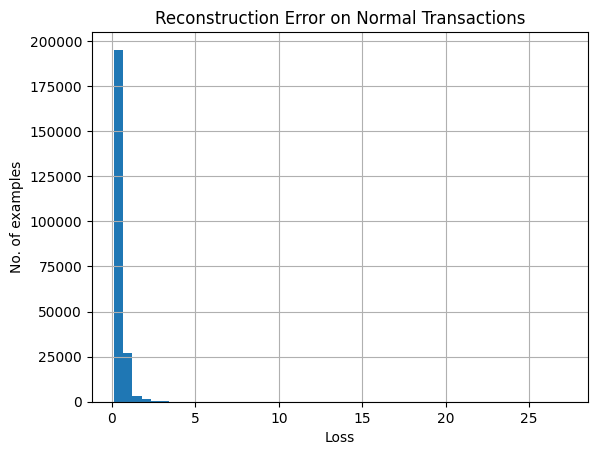

In [55]:
plt.hist(train_loss, bins=50)
plt.xlabel("Loss")
plt.ylabel("No. of examples")
plt.title("Reconstruction Error on Normal Transactions")
plt.grid()
plt.show()

### Evaluate on Test Data

In [56]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.greater(loss, threshold)  # True = predicted fraud

preds = predict(autoencoder, X_test, threshold)

In [57]:
print("Accuracy =", accuracy_score(y_test, preds))
print("Precision =", precision_score(y_test, preds))
print("Recall =", recall_score(y_test, preds))

Accuracy = 0.9305501913556407
Precision = 0.02181457610312345
Recall = 0.8979591836734694


### Threshold Tuning

In [60]:
# Get reconstruction losses on test set
reconstructions = autoencoder.predict(X_test)
test_loss = tf.keras.losses.mae(reconstructions, X_test).numpy()
print(test_loss)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
[6.40438043 0.72233942 0.38135505 ... 0.63995401 0.31369694 1.18874714]


In [63]:
# Threshold Tuning
thresholds = np.linspace(min(test_loss), max(test_loss), 100)
best_f1 = 0
best_threshold = 0
precisions, recalls, f1s = [], [], []

for t in thresholds:
    preds = test_loss > t
    p = precision_score(y_test, preds)
    r = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print("Best Threshold:", best_threshold)
print("Best F1 Score:", best_f1)

Best Threshold: 5.142178951452826
Best F1 Score: 0.3546099290780142


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


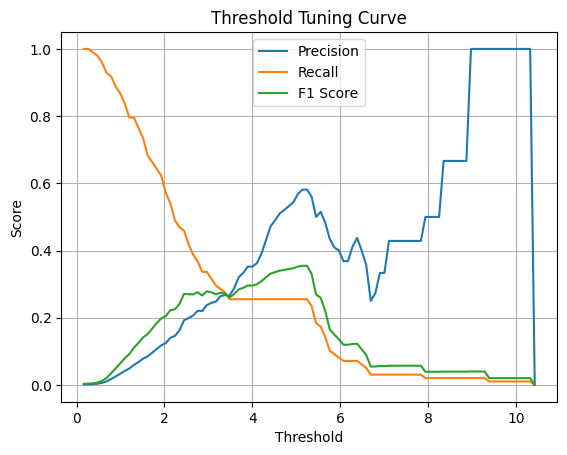

In [64]:
# Plot Precision, Recall, F1 vs Threshold
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning Curve")
plt.legend()
plt.grid(True)
plt.show()

In [65]:
final_preds = test_loss > best_threshold
print("\n📊 Classification Report:")
print(classification_report(y_test, final_preds))


📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.58      0.26      0.35        98

    accuracy                           1.00     56962
   macro avg       0.79      0.63      0.68     56962
weighted avg       1.00      1.00      1.00     56962

